Dans la cellule de code suivante, nous avons lancé plusieurs simulation de notre file pour observer l'évaluation du temps de réponse moyen pour chaque valeur de C {1; 2; 3; 6} en fonction de λ.

In [1]:
import routeur

LAMBDA_REQUETE = 2.3

C = 1

T_MAX = 1000

routeur.simul_fifo(LAMBDA_REQUETE, C, T_MAX)

{'temp_moyen_attente_client': 17.884529669698892,
 'taux_rejet': 0.22937803264225848}

In [2]:
def interval_conf_attente_client(lambda_requete, c, t_max):
    moy = 0
    elem = []
    for _ in range(ECHANTILLON):
        elem.append(routeur.simul_fifo(lambda_requete, c, t_max))
        moy += (elem[-1]["temp_moyen_attente_client"]) / ECHANTILLON
    
    # Estimation de la variance
    var = 0

    for i in range(ECHANTILLON):
        var += ((elem[i]["temp_moyen_attente_client"] - moy)**2) * (1 / (ECHANTILLON-1))
    
    d = 1.96*((var/ECHANTILLON)**0.5)

    return (moy-d, moy+d)
    


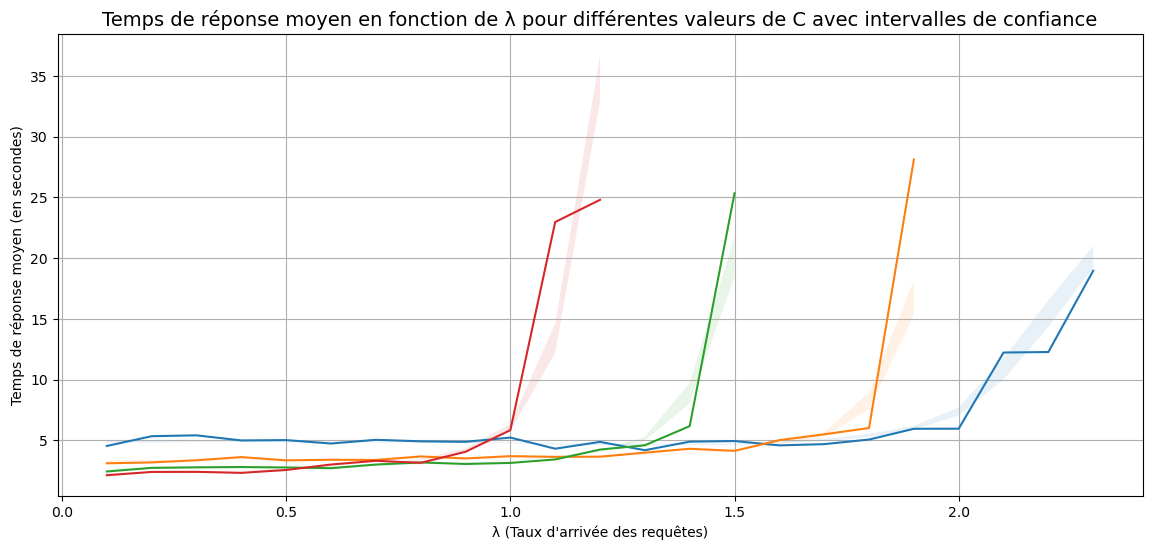

In [ ]:
import routeur
import matplotlib.pyplot as plt
import numpy as np


# Paramètres de la simulation
T_MAX = 1000  # Temps maximal de simulation
STEP = 0.1
ECHANTILLON = 100

# Valeurs possibles pour C
C_values = [1, 2, 3, 6]

# Liste pour stocker les résultats pour chaque valeur de C
data = []

# Simulation pour chaque valeur de C
for C in C_values:
    data.append({"temp_reponse_moyen" : [], "borne_inf" : [], "borne_sup" : [], "C" : C, "lambdas" : []})
    
    # Initialisation de lambda_requete pour chaque C
    lambda_requete = 0.1

    # Effectuer la simulation pour chaque valeur de lambda_requete
    while True:
        # Simulation
        resultats = routeur.simul_fifo(lambda_requete, C, T_MAX)

        # Vérification du taux de rejet
        if resultats["taux_rejet"] > 0.05:
            break
        
        # stock le resultat
        data[-1]["temp_reponse_moyen"].append(resultats["temp_moyen_attente_client"])
        data[-1]["lambdas"].append(lambda_requete)

        # calcul intervalle de confiance
        intervals = interval_conf_attente_client(lambda_requete, C, T_MAX)
        data[-1]["borne_inf"].append(intervals[0])
        data[-1]["borne_sup"].append(intervals[1])
        
        # Pas de lambda_requete
        lambda_requete += STEP

# Tracer les courbes pour chaque valeur de C
plt.figure(figsize=(14, 6))
for i in range(len(C_values)):
    plt.plot(data[i]["lambdas"], data[i]["temp_reponse_moyen"], linestyle='-', label=("C = " + str(data[i]["C"])))
    plt.fill_between(data[i]["lambdas"], data[i]["borne_inf"], data[i]["borne_sup"], alpha=.5)

# Ajouter un titre et des labels
plt.title("Temps de réponse moyen en fonction de λ pour différentes valeurs de C avec intervalles de confiance", size=14)
plt.xlabel("λ (Taux d'arrivée des requêtes)")
plt.ylabel("Temps de réponse moyen (en secondes)")
plt.grid(True)

# Affichage du graphique
plt.show()
